# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Advanced Data Science
## Lab 8: Recurrent Neural Networks

**Harvard University**<br>
**Fall 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Angelaki Kaxiras<br>
**Content:** Srivatsan Srinivasan, Pavlos Protopapas, Chris Tanner

In [1]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals

In this lab we will look at Recurrent Neural Networks (RNNs), LSTMs and their building blocks.

By the end of this lab, you should:

- know how to put together the building blocks used in RNNs and its variants (GRU, LSTM) in `keras` with an example.
- have a good undertanding on how sequences -- any data that has some temporal semantics (e.g., time series, natural language, images etc.) -- fit into and benefit from a recurrent architecture
- be familiar with preprocessing text and dynamic embeddings
- be familiar with gradient issues on RNNs processing longer sentence lengths
- understand different kinds of LSTM architectures, classifiers, sequence to sequence models and their far-reaching applications


## 1. IMDb Review Classification: Feedforward, CNN, RNN, LSTM



In this task, we are going to do sentiment classification on a movie review dataset. We are going to build a feedforward net, a convolutional neural net, a recurrent net and combine one or more of them to understand performance of each of them. A sentence can be thought of as a sequence of words that collectively represent meaning. Individual words impact the meaning. Thus, the context matters; words that occur earlier in the sentence influence the sentence's structure and meaning in the latter part of the sentence (e.g., Jose asked Anqi if she were going to the library today). Likewise, words that occur later in a sentence can affect the meaning of earlier words (e.g., Apple is an interesting company). As we have seen in lecture, if we wish to make use of a full sentence's context in both directions, then we should use a bi-directional RNN (e.g., Bi-LSTM). For the purpose of this tutorial, we are going to restrict ourselves to only uni-directional RNNs.

In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
# from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers import Embedding
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
import numpy as np
# fix random seed for reproducibility
numpy.random.seed(1)

2023-09-21 14:39:51.590167: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 14:39:51.613692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 14:39:51.997645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# We want to have a finite vocabulary to make sure that our word matrices are not arbitrarily small
vocabulary_size = 10000

# We also want to have a finite length of reviews and not have to process really long sentences.
max_review_length = 500

Computers have no built-in knowledge of words or their meanings and cannot understand them in any rich way that humans do -- hence, the purpose of Natural Language Processing (NLP). As with any data science, computer science, machine learning task, the first crucial step is to clean (pre-process) your data so that you can soundly make use of it. Within NLP, this first step is called Tokenization and it concerns how to represent each token (a.k.a. word) of your corpus (i.e., dataset).

#### TOKENIZATION

A ``token`` refers to a single, atomic unit of meaning (i.e., a word). How should our computers represent each word? We could read in our corpus word by word and store each word as a String (data structure). However, Strings tend to use more computer memory than Integers and can become cumbersome. As long as we preserve the uniqueness of the tokens and are consistent, we are better off converting each distinct word to a distinct number (Integer). This is standard practice within NLP / computer science / data science, etc.
As a simple example of tokenization, we can see a small example.

If the five sentences below were our entire corpus, our conversion would look as follows:

1. i have books - [1, 4, 7]
2. interesting books are useful [10,2,9,8]
3. i have computers [1,4,6]
4. computers are interesting and useful [6,9,11,10,8]
5. books and computers are both valuable. [2,10,2,9,13,12]
6. Bye Bye [7,7]

Create tokens for vocabulary based on frequency of occurrence. Hence, we assign the following tokens

I-1, books-2, computers-3, have-4, are-5, computers-6,bye-7, useful-8, are-9, and-10,interesting-11, valuable-12, both-13

Thankfully, our dataset is already represented in such a tokenized form.

**NOTE:** Often times, depending on your NLP task, it is useful to also perform other pre-processing, cleaning steps, such as:
- treating each punctuation mark as a token (e.g., , . ! ? are each separate tokens)
- lower-casing all words (so that a given word isn't treated differently just because it starts a sentence or not)
- separating each sentence with a unique symbol (e.g., <S> and </S>)
- removing words that are incredibly common (e.g., function words, (in)definite articles). These are referred to as 'stopwords'). For language modelling, we DO NOT remove stopwords. A sentence's meaning needs to include all of the original words.

#### Load data

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print('Number of reviews', len(X_train))
print('Length of first and fifth review before padding', len(X_train[0]) ,len(X_train[4]))
print('First review', X_train[0])
print('First label', y_train[0])

17464789/17464789 [==============================] - 1s 0us/step
Number of reviews 25000
Length of first and fifth review before padding 218 147
First review [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104,

#### Preprocess data

If we were training our RNN one sentence at a time, it would be okay to have sentences of varying lengths. However, as with any neural network, it can be sometimes be advantageous to train inputs in batches. When doing so with RNNs, our input tensors need to be of the same length/dimensions. Thus, let's pad our sentences.

In [4]:
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth review after padding 500 500


### MODEL 1A : FEED-FORWARD NETWORKS WITHOUT EMBEDDINGS 

Let us build a single-layer feed-forward net with a hidden layer of 250 nodes. Each input would be a 500-dim vector of tokens since we padded all our sequences to size 500.

<br>
<div class="exercise"  style="background-color:#b3e6ff">
<b>EXERCISE</b>: Calculate the number of parameters involved in this network and implement a feedforward net to do classification without looking at cells below.
</div>

In [5]:
model = Sequential()

model.add(Dense(250, activation='relu',input_dim=max_review_length))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

2023-09-21 14:40:03.295035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 14:40:03.385805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 14:40:03.386086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               125250    
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                                 
Total params: 125501 (490.24 KB)
Trainable params: 125501 (490.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


2023-09-21 14:40:07.566698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-21 14:40:07.583894: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe9751c6150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-21 14:40:07.583907: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-09-21 14:40:07.607856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-21 14:40:07.870688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-21 14:40:07.930689: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-21 14:40:07.99

196/196 - 3s - loss: 177.3750 - accuracy: 0.5039 - val_loss: 90.6364 - val_accuracy: 0.5073 - 3s/epoch - 15ms/step
Epoch 2/10
196/196 - 1s - loss: 45.8141 - accuracy: 0.5786 - val_loss: 44.9000 - val_accuracy: 0.5039 - 1s/epoch - 7ms/step
Epoch 3/10
196/196 - 1s - loss: 15.7880 - accuracy: 0.6554 - val_loss: 26.4167 - val_accuracy: 0.5067 - 951ms/epoch - 5ms/step
Epoch 4/10
196/196 - 1s - loss: 6.4456 - accuracy: 0.7210 - val_loss: 17.6518 - val_accuracy: 0.5088 - 1s/epoch - 6ms/step
Epoch 5/10
196/196 - 1s - loss: 3.1993 - accuracy: 0.7581 - val_loss: 12.1551 - val_accuracy: 0.5104 - 1s/epoch - 6ms/step
Epoch 6/10
196/196 - 1s - loss: 1.9322 - accuracy: 0.7785 - val_loss: 9.6879 - val_accuracy: 0.5045 - 1s/epoch - 6ms/step
Epoch 7/10
196/196 - 1s - loss: 1.3275 - accuracy: 0.7994 - val_loss: 7.5593 - val_accuracy: 0.5114 - 1s/epoch - 7ms/step
Epoch 8/10
196/196 - 1s - loss: 0.9882 - accuracy: 0.8155 - val_loss: 7.0871 - val_accuracy: 0.5091 - 1s/epoch - 7ms/step
Epoch 9/10
196/196 - 1

<div class="discussion"  style="background-color:#F5E4C3">
    <b>Discussion:</b> Why was the performance bad? What was wrong with tokenization?
</div>

### MODEL 1B : FEED-FORWARD NETWORKS WITH EMBEDDINGS

#### What is an embedding layer ? 

An embedding is a "distributed representation" (e.g., vector) of a particular atomic item (e.g., word token, object, etc). When representing items by embeddings:
- each distinct item should be represented by its own unique embedding
- the semantic similarity between items should correspond to the similarity between their respective embeddings (i.e., words that are more similar to one another should have embeddings that are more similar to each other).

There are essentially an infinite number of ways to create such embeddings, and since these representations have such a great influence on the performance of our models, there has been an incredible amount of research dedicated to this very aspect. If you are interested in learning more, start with the astromonically impactful papers of [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [GloVe](https://www.aclweb.org/anthology/D14-1162.pdf).

In general, though, one can view the embedding process as a linear projection from one vector space to another (e.g., a vector space of unique words being mapped to a world of fixed-length, dense vectors filled with continuous-valued numbers. For NLP, we usually use embeddings to project the one-hot encodings of words (i.e., a vector that is the length of the entire vocabulary, and it is filled with all zeros except for a single value of 1 that corresponds to the particular word) on to a lower-dimensional continuous space (e.g., vectors of size 100) so that the input surface is dense and possibly smooth. Thus, one can view this embedding layer process as just a transformation from $\mathbb{R}^{inp}$ to $\mathbb{R}^{emb}$

In [6]:
embedding_dim = 100

When you create an Embedding layer, TensorFlow initializes an embedding matrix with random values. The shape of this matrix is (input_dim, output_dim), where input_dim is the size of the input vocabulary, and output_dim is the dimension of the embedding vectors. Each row in this matrix corresponds to an index in the input vocabulary.

Input Transformation: When you pass integer sequences to the embedding layer, it essentially looks up the corresponding rows in the embedding matrix. If the input is a sequence of integer indices [3, 7, 2], the embedding layer will retrieve the rows with indices 3, 7, and 2 from the embedding matrix. These rows are the dense embeddings for the input tokens.

In [7]:
model = Sequential()

# inputs will be converted from batch_size * sentence_length to batch_size*sentence_length*embedding _dim
model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense_2 (Dense)             (None, 250)               12500250  
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 13500501 (51.50 MB)
Trainable params: 13500501 (51.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)

# evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2
196/196 - 8s - loss: 0.0136 - accuracy: 0.9979 - val_loss: 0.4066 - val_accuracy: 0.8696 - 8s/epoch - 39ms/step
Epoch 2/2
196/196 - 6s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4620 - val_accuracy: 0.8716 - 6s/epoch - 30ms/step
Accuracy: 87.16%


### MODEL 2 : CONVOLUTIONAL NEURAL NETWORKS (CNN)
Text can be thought of as 1-dimensional sequence (a single, long vector) and we can apply 1D Convolutions over a set of word embeddings. Let us walk through convolutions on text data with [this blog](http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/). If you want to learn more, read this [published and well-cited paper](https://www.aclweb.org/anthology/I17-1026.pdf) from my friend, Byron Wallace.

Fit a 1D convolution with 200 filters, kernel size 3, followed by a feed-forward layer of 250 nodes, and ReLU and Sigmoid activations as appropriate.

In [11]:
# %load sol2.py
# create the CNN
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_review_length))
model.add(Convolution1D(filters=200, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# train the CNN
model.fit(X_train, y_train, epochs=2, batch_size=128)

# evalute the CNN
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 500, 200)          60200     
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 200)          0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 50000)             0         
                                                                 
 dense_4 (Dense)             (None, 250)               12500250  
                                                                 
 dense_5 (Dense)             (None, 1)                 251       
                                                      

2023-09-21 14:42:34.537747: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


196/196 [==============================] - 16s 66ms/step - loss: 0.4951 - accuracy: 0.7290
Epoch 2/2
196/196 [==============================] - 10s 53ms/step - loss: 0.1877 - accuracy: 0.9277
Accuracy: 87.80%


### MODEL 3 : Simple RNN

Two great blogs that are helpful for understanding the workings of a RNN and LSTM are

1. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
2. http://colah.github.io/posts/2015-08-Understanding-LSTMs/

At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

Mathematically, a simpleRNN can be defined by the following recurrence relation.

<center>$h_t = \sigma(W([h_{t-1},x_{t}])+b)$
    
If we extend this recurrence relation to the length of sequences we have in hand, our RNN architecture can be viewed as follows (this is also referred to as 'unrolling' the network):

<img src="files/fig/LSTM_classification.jpg" width="400">

In [12]:
# %load sol3.py
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_review_length))
model.add(SimpleRNN(100))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=20, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1020201 (3.89 MB)
Trainable params: 1020201 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
1563/1563 [==============================] - 165s 105ms/step - loss: 0.6101 - accuracy: 0.6525
Epoch 2/20
1563/1563 [==============================] - 125s 80ms/step - loss: 0.4694 - accuracy: 0.7768
Epoch 3/20
1563/1563 [==============================] - 120s 77m

#### RNNs and vanishing/exploding gradients

Let us use sigmoid activations as example. Derivative of a sigmoid can be written as 
<center> $\sigma'(x) = \sigma(x) \cdot \sigma(1-x)$. </center>

<img src = "files/fig/vanishing_gradients.png">
<br>

Remember, an RNN is a "really deep" feed-forward-esque network (when unrolled in time). Hence, backpropagation happens from $h_t$ all the way to $h_1$. Also realize that sigmoid gradients are multiplicatively dependent on the value of sigmoid. Hence, if the non-activated output of any layer $h_l$ is < 0, then $\sigma$ tends to 0, effectively "vanishing" the gradient. Any layer that the current layer backprops to $H_{1:L-1}$ does not learn anything useful out of the gradients.

#### LSTMs and GRU
LSTM and GRU are two sophisticated implementations of RNNs that have gates (one could say that their success hinges on using gates). A gate emits probability between 0 and 1. For instance, LSTM is built on these state updates:

$L$ is a linear transformation $L(x) = W*x + b.$

$f_t = \sigma(L([h_{t-1},x_t))$

$i_t = \sigma(L([h_{t-1},x_t))$

$o_t = \sigma(L([h_{t-1},x_t))$

$\hat{C}_t = \tanh(L([h_{t-1},x_t))$

$C_t = f_t * C_{t-1}+i_t*\hat{C}_t$  (Using the forget gate, the neural network can learn to control how much information it has to retain or forget)

$h_t = o_t * \tanh(c_t)$



### MODEL 4 : LSTM

Now, let's use an LSTM model to do classification! To make it a fair comparison to the SimpleRNN, let's start with the same architecture hyper-parameters (e.g., number of hidden nodes, epochs, and batch size). Then, experiment with increasing the number of nodes, stacking multiple layers, applying dropouts etc. Check the number of parameters that this model entails.

In [13]:
# %load sol4.py
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=64)

# evaluation of the LSTM's performance
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1080501 (4.12 MB)
Trainable params: 1080501 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
391/391 [==============================] - 38s 92ms/step - loss: 0.4244 - accuracy: 0.8017
Epoch 2/3
391/391 [==============================] - 21s 53ms/step - loss: 0.3684 - accuracy: 0.8363
Epoch 3/3
391/391 [==============================] - 15s 38ms/step - loss

### MODEL 5 : CNN + LSTM 

CNNs are good at learning spatial features, and sentences can be thought of as 1-D spatial vectors (dimensionality is determined by the number of words in the sentence). We apply an LSTM over the features learned by the CNN (after a maxpooling layer). This leverages the power of CNNs and LSTMs combined! We expect the CNN to be able to pick out invariant features across the 1-D spatial structure (i.e., sentence) that characterize good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer, and the final classification can be made via a feed-forward connection to a single node.

In [15]:
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_dim, input_length=max_review_length))
model.add(Convolution1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           9632      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 32)           0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1062933 (4.05 MB)
Trainable params: 1062933 (4.05 MB)
Non-trainable params: 0 (0.00 Byte)
________________

### CONCLUSION

We saw the power of sequence models and how they are useful in text classification. They give a solid performance, low memory footprint (thanks to shared parameters) and are able to understand and leverage the temporally connected information contained in the inputs. There is still an open debate about the performance vs memory benefits of CNNs vs RNNs in the research community.

As a side-note and bit of history: how amazing is it that we can construct these neural networks, train them, and evaluate them in just a few lines of code?! Imagine if we didn't have deep learning libraries like Keras and Tensorflow; we'd have to write backpropagation and gradient descent by hand. Our last network could easily require thousands of lines of code and many hours of debugging. This is what many people did just 8 years ago, since deep learning wasn't common and the community hadn't yet written nicely packaged libraries. Many libraries have come and gone, but nowadays most people use either Tensorflow/Keras (by Google) or PyTorch (by Facebook). I expect them to remain as great libraries for the foreseeable future, so if you're interested in deep learning, it's worth the investment to learn one, or both, of them well.

## 2. 231+432 = 665.... It's not ? Let's ask our LSTM

In this exercise, we are going to teach addition to our model. Given two numbers (<999), the model outputs their sum (<9999). The input is provided as a string '231+432' and the model will provide its output as ' 663' (Here the empty space is the padding character). We are not going to use any external dataset and are going to construct our own dataset for this exercise.

The exercise we attempt to do effectively "translates" a sequence of characters '231+432' to another sequence of characters ' 663' and hence, this class of models are called sequence-to-sequence models (aka seq2seq). Such architectures have profound applications in several real-life tasks such as machine translation, summarization, image captioning etc.

To be clear, sequence-to-sequence (aka seq2seq) models take as input a sequence of length N and return a sequence of length M, where N and M may or may not differ, and every single observation/input may be of different values, too. For example, machine translation concerns converting text from one natural language to another (e.g., translating English to French). Google Translate is an example, and their system is a seq2seq model. The input (e.g., an English sentence) can be of any length, and the output (e.g., a French sentence) may be of any length.

**Background knowledge:** The earliest and most simple seq2seq model works by having one RNN for the input, just like we've always done, and we refer to it as being an "encoder." The final hidden state of the encoder RNN is fed as input to another RNN that we refer to as the "decoder." The job of the decoder is to generate each token, one word at a time. This may seem really limiting, as it relies on the encoder encapsulating the entire input sequence with just 1 hidden layer. It seems unrealistic that we could encode an entire meaning of a sentence with just one hidden layer. Yet, results even in this simplistic manner can be quite impressive. In fact, these early results were compelling enough that these models immediately replaced the decades of earlier machine translation work.

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, RepeatVector, TimeDistributed
import numpy as np
from six.moves import range

2023-09-21 20:40:41.429050: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 20:40:41.453282: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 20:40:41.886665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### The less interesting data generation and preprocessing

In [2]:
class CharacterTable(object):
    # In Python 2, the object argument was often used when defining classes to indicate that this class is a new-style class. 
    # In Python 3 and later, this argument is optional, so you can define classes without specifying object.
    def __init__(self, chars):        
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    # converts a String of characters into a one-hot embedding/vector
    def encode(self, C, num_rows):        
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    # converts a one-hot embedding/vector into a String of characters
    def decode(self, x, calc_argmax=True):        
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


In [3]:
TRAINING_SIZE = 50000
DIGITS = 3
MAXOUTPUTLEN = DIGITS + 1
MAXLEN = DIGITS + 1 + DIGITS

chars = '0123456789+ '
ctable = CharacterTable(chars)

In [4]:
def return_random_digit():
  return np.random.choice(list('0123456789'))  

# generate a new number of length `DIGITS`
def generate_number():
  num_digits = np.random.randint(1, DIGITS + 1)  
  return int(''.join( return_random_digit()
                      for i in range(num_digits)))

# generate `TRAINING_SIZE` # of pairs of random numbers
def data_generate(num_examples):
  questions = []
  answers = []
  seen = set()
  print('Generating data...')
  while len(questions) < TRAINING_SIZE:      
      a, b = generate_number(), generate_number()
        
      # don't allow duplicates; this is good practice for training,
      # as we will minimize memorizing seen examples
      key = tuple(sorted((a, b)))
      if key in seen:
          continue
      seen.add(key)
    
      # pad the data with spaces so that the length is always MAXLEN.
      q = '{}+{}'.format(a, b)
      query = q + ' ' * (MAXLEN - len(q))
      ans = str(a + b)
    
      # answers can be of maximum size DIGITS + 1.
      ans += ' ' * (MAXOUTPUTLEN - len(ans))
      questions.append(query)
      answers.append(ans)
  print('Total addition questions:', len(questions))
  return questions, answers

def encode_examples(questions, answers):
  x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool_)
  y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool_)
  for i, sentence in enumerate(questions):
      x[i] = ctable.encode(sentence, MAXLEN)
  for i, sentence in enumerate(answers):
      y[i] = ctable.encode(sentence, DIGITS + 1)

  indices = np.arange(len(y))
  np.random.shuffle(indices)
  return x[indices],y[indices]

In [5]:
q,a = data_generate(TRAINING_SIZE)
x,y = encode_examples(q,a)

# divides our data into training and validation
split_at = len(x) - len(x) // 10
x_train, x_val, y_train, y_val = x[:split_at], x[split_at:],y[:split_at],y[split_at:]

print('Training Data shape:')
print('X : ', x_train.shape)
print('Y : ', y_train.shape)

print('Sample Question(in encoded form) : ', x_train[0], y_train[0])
print('Sample Question(in decoded form) : ', ctable.decode(x_train[0]),'Sample Output : ', ctable.decode(y_train[0]))

Generating data...
Total addition questions: 50000
Training Data shape:
X :  (45000, 7, 12)
Y :  (45000, 4, 12)
Sample Question(in encoded form) :  [[False False False False False False False  True False False False False]
 [False False False False False False False False False False  True False]
 [False False False False False False False False False False  True False]
 [False  True False False False False False False False False False False]
 [False False False  True False False False False False False False False]
 [False False False False False False False False False  True False False]
 [False False False False False  True False False False False False False]] [[False False False False False False False False False  True False False]
 [False False False False False False False False  True False False False]
 [False False False  True False False False False False False False False]
 [ True False False False False False False False False False False False]]
Sample Question(in decode

#### Let's learn two wrapper functions in Keras - TimeDistributed and RepeatVector with some dummy examples.

**TimeDistributed** is a wrapper function call that applies an input operation on all the timesteps of an input data. For instance, if I have a feed-forward network which converts a 10-dim vector to a 5-dim vector, then wrapping this TimeDistributed layer on that feed-forward operation would convert a batch_size  \* sentence_len \* vector_len(=10) to batch_size  \* sentence_len \*  output_len(=5)

In [6]:
model = Sequential()
#Inputs to it will be batch_size*time_steps*input_vector_dim(to Dense)
# Output will be batch_size*time_steps* output_vector_dim
# Here, Dense() converts a 5-dim input vector to a 8-dim vector.
model.add(TimeDistributed(Dense(8), input_shape=(3, 5)))
input_array = np.random.randint(10, size=(1,3,5))
print("Shape of input : ", input_array.shape)

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print("Shape of output : ", output_array.shape)

2023-09-21 20:40:49.935467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 20:40:49.953511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 20:40:49.953867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Shape of input :  (1, 3, 5)
1/1 [==============================] - 1s 575ms/step
Shape of output :  (1, 3, 8)


2023-09-21 20:40:51.069736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


**RepeatVector** repeats the vector a specified number of times. Dimension changes from batch_size * number of elements to batch_size* number of repetitions * number of elements.

In [7]:
model = Sequential()
# converts from 1*10 to 1*6
model.add(Dense(6, input_dim=10))
print(model.output_shape)

# converts from 1*6 to 1*3*6
model.add(RepeatVector(3))
print(model.output_shape) 

input_array = np.random.randint(1000, size=(1, 10))
print("Shape of input : ", input_array.shape)

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)

print("Shape of output : ", output_array.shape)
# note: `None` is the batch dimension
print('Input : ', input_array[0])
print('Output : ', output_array[0])

(None, 6)
(None, 3, 6)
Shape of input :  (1, 10)
1/1 [==============================] - 0s 20ms/step
Shape of output :  (1, 3, 6)
Input :  [538 688 666 152 593  47 514 640 343 146]
Output :  [[  698.6417    214.78064  -460.49487  -473.46393 -1334.4592   -334.55194]
 [  698.6417    214.78064  -460.49487  -473.46393 -1334.4592   -334.55194]
 [  698.6417    214.78064  -460.49487  -473.46393 -1334.4592   -334.55194]]


### MODEL ARCHITECTURE

<img src="files/fig/LSTM_addition.jpg" width="400">

**Note:** Whenever you are initializing a LSTM in Keras, by the default the option `return_sequences = False`. This means that at the end of the step the next component will only get to see the final hidden layer's values. On the other hand, if you set `return_sequences = True`, the LSTM component will return the hidden layer at each time step. It means that the next component should be able to consume inputs in that form. 

Think how this statement is relevant in terms of this model architecture and the TimeDistributed module we just learned.

Build an encoder and decoder both single layer 128 nodes and an appropriate dense layer as needed by the model.

Build model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72192     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 4, 128)            0         
 tor)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            131584    
                                                                 
 time_distributed_1 (TimeDi  (None, 4, 12)             1548      
 stributed)                                                      
                                                                 
Total params: 205324 (802.05 KB)
Trainable params: 205324 (802.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

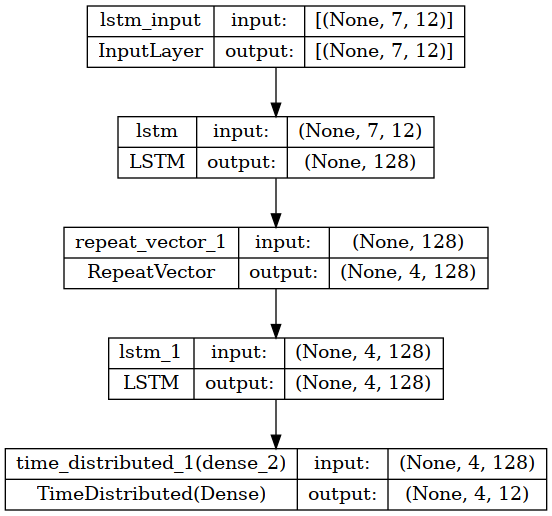

In [8]:
from tensorflow.keras.utils import plot_model

# Hyperaparams
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()

#ENCODING
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(RepeatVector(MAXOUTPUTLEN))
# 4 outputs, each output will see the encoder hidden layers (the same layer)
# 4 outputs are like the sequence inputs for the decoder

#DECODING
for _ in range(LAYERS):
    # return hidden layer at each time step
    model.add(RNN(HIDDEN_SIZE, return_sequences=True)) 

model.add(TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Let's check how well our model trained.

In [22]:
x_val[0].shape

(7, 12)

In [23]:
x_val[np.array([0])].shape

(1, 7, 12)

In [29]:
model.predict(x_val[np.array([0])], verbose=0).shape

(1, 4, 12)

In [30]:
model.predict(x_val[np.array([0])], verbose=0).argmax(axis=-1)

array([[6, 2, 9, 0]])

In [31]:
for iteration in range(1, 10):
    print()  
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so
    # we can visualize errors.
    print('Finished iteration ', iteration)
    numcorrect = 0
    numtotal = 20
    
    for i in range(numtotal):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=True)
        print('Question', q, end=' ')
        print('True', correct, end=' ')
        print('Guess', guess, end=' ')
        if guess == correct :
          print('Good job')
          numcorrect += 1
        else:
          print('Fail')
    print('The model scored ', numcorrect*100/numtotal,' % in its test.')


352/352 [==============================] - 3s 10ms/step - loss: 0.8493 - accuracy: 0.6801 - val_loss: 0.8020 - val_accuracy: 0.6931
Finished iteration  1
Question 28+823  True 851  Guess 850  Fail
Question 32+12   True 44   Guess 44   Good job
Question 17+266  True 283  Guess 284  Fail
Question 260+79  True 339  Guess 359  Fail
Question 603+4   True 607  Guess 607  Good job
Question 91+693  True 784  Guess 776  Fail
Question 39+521  True 560  Guess 560  Good job
Question 422+280 True 702  Guess 729  Fail
Question 569+686 True 1255 Guess 1367 Fail
Question 3+460   True 463  Guess 464  Fail
Question 648+9   True 657  Guess 657  Good job
Question 850+416 True 1266 Guess 1265 Fail
Question 938+45  True 983  Guess 983  Good job
Question 774+40  True 814  Guess 807  Fail
Question 4+836   True 840  Guess 830  Fail
Question 583+661 True 1244 Guess 1225 Fail
Question 68+820  True 888  Guess 899  Fail
Question 27+634  True 661  Guess 660  Fail
Question 36+64   True 100  Guess 900  Fail
Question

#### EXERCISE

 * Try changing the hyperparams, use other RNNs, more layers, check if increasing the number of epochs is useful.

 * Try reversing the data from validation set and check if commutative property of addition is learned by the model.
 * Try printing the hidden layer with two inputs that are commutative and check if the hidden representations it learned are same or similar. Do we expect it to be true? If so, why? If not why? You can access the layer using an index with model.layers and layer.output will give the output of that layer.

* Try doing addition in the RNN model the same way we do by hand. Reverse the order of digits and at each time step, input two digits get an output use the hidden layer and input next two digits and so on.(units in the first time step, tens in the second time step etc.)